#  Estimating maximun likelihood of numbers of cars arriving at charging station for each hour of the day

1. Group data set by the hour of arrival
2. Calculate lambda parameter for poisson distribution unsing maximum likelihood method for arrivals for each hour
3. Calculate same parameter lambda in dynamic for each month of the data I have
4. Plot the change dynamic into a graph

In [200]:
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats
import numpy as np
import seaborn as sns

In [2]:
#changong data types to datetime format for users table

users_to_clean = pd.read_csv('./data/users.csv')
users_to_clean['Modified'] = pd.to_datetime(users_to_clean.modifiedAt, infer_datetime_format=True)  
users_to_clean['Departure'] = pd.to_datetime(users_to_clean.requestedDeparture, infer_datetime_format=True)
users = users_to_clean.drop(columns = ['requestedDeparture', 'modifiedAt', 'Unnamed: 0'])
users.head()

,WhPerMile,kWhRequested,milesRequested,minutesAvailable,paymentRequired,userID,Modified,Departure
0,350,59.5,170,550,True,22,2018-04-30 15:08:54+00:00,2018-05-01 00:17:49+00:00
1,400,8.0,20,60,True,61,2018-05-07 14:38:32+00:00,2018-05-07 15:38:18+00:00
2,400,8.0,20,648,True,61,2018-05-07 15:40:44+00:00,2018-05-08 01:26:18+00:00
3,400,28.0,70,648,True,61,2018-05-07 15:41:04+00:00,2018-05-08 01:26:18+00:00
4,350,17.5,50,546,True,22,2018-05-11 15:18:23+00:00,2018-05-12 00:23:01+00:00


In [84]:
#changing data types to datetime format for users table

charging_to_clean = pd.read_csv('./data/charging.csv')
charging_to_clean['ConnectionTime'] = pd.to_datetime(charging_to_clean.connectionTime, infer_datetime_format=True) 
charging_to_clean['DisconnectTime'] = pd.to_datetime(charging_to_clean.disconnectTime, infer_datetime_format=True) 
charging_to_clean['DoneCharging'] = pd.to_datetime(charging_to_clean.doneChargingTime, infer_datetime_format=True) 

charging = charging_to_clean.drop(columns = ['connectionTime', 'disconnectTime', 'doneChargingTime', 'Unnamed: 0'])
charging.head()

,_id,clusterID,kWhDelivered,sessionID,siteID,spaceID,stationID,timezone,userID,ConnectionTime,DisconnectTime,DoneCharging
0,5bc90cb9f9af8b0d7fe77cd2,39,7.932,2_39_78_362_2018-04-25 11:08:04.400812,2,CA-496,2-39-78-362,America/Los_Angeles,NaN,2018-04-25 11:08:04+00:00,2018-04-25 13:20:10+00:00,2018-04-25 13:21:10+00:00
1,5bc90cb9f9af8b0d7fe77cd3,39,10.013,2_39_95_27_2018-04-25 13:45:09.617470,2,CA-319,2-39-95-27,America/Los_Angeles,NaN,2018-04-25 13:45:10+00:00,2018-04-26 00:56:16+00:00,2018-04-25 16:44:15+00:00
2,5bc90cb9f9af8b0d7fe77cd4,39,5.257,2_39_79_380_2018-04-25 13:45:49.962001,2,CA-489,2-39-79-380,America/Los_Angeles,NaN,2018-04-25 13:45:50+00:00,2018-04-25 23:04:45+00:00,2018-04-25 14:51:44+00:00
3,5bc90cb9f9af8b0d7fe77cd5,39,5.177,2_39_79_379_2018-04-25 14:37:06.460772,2,CA-327,2-39-79-379,America/Los_Angeles,NaN,2018-04-25 14:37:06+00:00,2018-04-25 23:55:34+00:00,2018-04-25 16:05:22+00:00
4,5bc90cb9f9af8b0d7fe77cd6,39,10.119,2_39_79_381_2018-04-25 14:40:33.638896,2,CA-490,2-39-79-381,America/Los_Angeles,NaN,2018-04-25 14:40:34+00:00,2018-04-25 23:03:12+00:00,2018-04-25 17:40:30+00:00


In [188]:
hours = list(range(24))

## Group data set by the hour of arrival

In [159]:
#a function to slice rows from the charging dataframe with sessions happened in a certain hour
def arrivals_by_hour(df, hour):
    new_df = charging[charging.ConnectionTime.dt.hour == hour]
    return new_df

#charging[charging.ConnectionTime.dt.hour == 2]

In [160]:
arrivals_by_hour(charging, 14)

,_id,clusterID,kWhDelivered,sessionID,siteID,spaceID,stationID,timezone,userID,ConnectionTime,DisconnectTime,DoneCharging
3,5bc90cb9f9af8b0d7fe77cd5,39,5.177,2_39_79_379_2018-04-25 14:37:06.460772,2,CA-327,2-39-79-379,America/Los_Angeles,NaN,2018-04-25 14:37:06+00:00,2018-04-25 23:55:34+00:00,2018-04-25 16:05:22+00:00
4,5bc90cb9f9af8b0d7fe77cd6,39,10.119,2_39_79_381_2018-04-25 14:40:33.638896,2,CA-490,2-39-79-381,America/Los_Angeles,NaN,2018-04-25 14:40:34+00:00,2018-04-25 23:03:12+00:00,2018-04-25 17:40:30+00:00
5,5bc90cb9f9af8b0d7fe77cd7,39,7.910,2_39_139_28_2018-04-25 14:43:49.647430,2,CA-303,2-39-139-28,America/Los_Angeles,NaN,2018-04-25 14:43:50+00:00,2018-04-26 01:17:30+00:00,2018-04-25 16:18:28+00:00
6,5bc90cb9f9af8b0d7fe77cd8,39,15.294,2_39_91_441_2018-04-25 14:47:41.776352,2,CA-499,2-39-91-441,America/Los_Angeles,NaN,2018-04-25 14:47:42+00:00,2018-04-25 18:27:51+00:00,2018-04-25 18:27:42+00:00
7,5bc90cb9f9af8b0d7fe77cd9,39,6.953,2_39_79_377_2018-04-25 14:58:25.255583,2,CA-325,2-39-79-377,America/Los_Angeles,NaN,2018-04-25 14:58:25+00:00,2018-04-25 19:06:29+00:00,2018-04-25 16:48:29+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
27942,5e86838df9af8b33946c3b8e,39,7.929,2_39_79_382_2020-03-17 14:26:23.895078,2,CA-491,2-39-79-382,America/Los_Angeles,4701.0,2020-03-17 14:26:24+00:00,2020-03-17 22:51:55+00:00,2020-03-17 17:07:34+00:00
27972,5ea7790af9af8b4e1ade47c2,39,32.568,2_39_79_378_2020-04-11 14:00:46.298459,2,CA-326,2-39-79-378,America/Los_Angeles,3424.0,2020-04-11 14:00:46+00:00,2020-04-11 18:46:00+00:00,2020-04-11 18:45:55+00:00
28017,5ef9360af9af8b0c125996e9,39,0.510,2_39_125_21_2020-06-12 14:50:16.823511,2,CA-311,2-39-125-21,America/Los_Angeles,1920.0,2020-06-12 14:50:17+00:00,2020-06-12 15:00:16+00:00,2020-06-12 15:00:11+00:00
28026,5f02708bf9af8b1a991c4f63,39,3.308,2_39_127_19_2020-06-19 14:46:22.542546,2,CA-309,2-39-127-19,America/Los_Angeles,1920.0,2020-06-19 14:46:23+00:00,2020-06-19 15:45:57+00:00,2020-06-19 15:45:52+00:00


## Calculate lambda parameter for poisson distribution unsing maximum likelihood method for arrivals for each hour

In [164]:
#data for all sessions that started at 14.00
arrived_14 = arrivals_by_hour(charging, 14)
arrived_14_day = arrived_14.groupby(
    [arrived_14.ConnectionTime.dt.year, 
     arrived_14.ConnectionTime.dt.month, 
     arrived_14.ConnectionTime.dt.day]).count()

In [165]:
arrived_14_day.describe()

,_id,clusterID,kWhDelivered,sessionID,siteID,spaceID,stationID,timezone,userID,ConnectionTime,DisconnectTime,DoneCharging
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,3.535714,3.535714,3.535714,3.535714,3.535714,3.535714,3.535714,3.535714,1.209184,3.535714,3.535714,3.482143
std,2.867714,2.867714,2.867714,2.867714,2.867714,2.867714,2.867714,2.867714,1.298087,2.867714,2.867714,2.917394
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000
50%,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000
75%,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,2.000000,5.000000,5.000000,5.000000
max,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,6.000000,14.000000,14.000000,14.000000


In [166]:
#calculating the maximul likelihood estimator for each months
#for poisson, max likelihood estimator is sample mean
arrived_14_day._id.describe()

count    392.000000
mean       3.535714
std        2.867714
min        1.000000
25%        1.000000
50%        2.000000
75%        5.000000
max       14.000000
Name: _id, dtype: float64

In [171]:
arrived_16 = arrivals_by_hour(charging, 16)
arrived_16
arrived_16_day = arrived_16.groupby(
    [arrived_16.ConnectionTime.dt.year, 
     arrived_16.ConnectionTime.dt.month, 
     arrived_16.ConnectionTime.dt.day]).count()
arrived_16_day._id.describe()

count    618.000000
mean       7.456311
std        4.368986
min        1.000000
25%        4.000000
50%        8.000000
75%       11.000000
max       22.000000
Name: _id, dtype: float64

In [168]:
arrived_9 = arrivals_by_hour(charging, 9)
arrived_9_day = arrived_9.groupby(
    [arrived_9.ConnectionTime.dt.year, 
     arrived_9.ConnectionTime.dt.month, 
     arrived_9.ConnectionTime.dt.day]).count()
arrived_9_day.describe()

,_id,clusterID,kWhDelivered,sessionID,siteID,spaceID,stationID,timezone,userID,ConnectionTime,DisconnectTime,DoneCharging
count,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000
mean,1.027778,1.027778,1.027778,1.027778,1.027778,1.027778,1.027778,1.027778,0.416667,1.027778,1.027778,0.944444
std,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.500000,0.166667,0.166667,0.333333
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000
50%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000


In [190]:
#combining all calculation in one function
def max_likelihood_by_hour(hour, df = charging):
    new_df = charging[charging.ConnectionTime.dt.hour == hour]
    groupped = new_df.groupby([new_df.ConnectionTime.dt.year, 
                    new_df.ConnectionTime.dt.month, 
                    new_df.ConnectionTime.dt.day]).count()
    return groupped['_id'].mean()

In [193]:
#calculating likelehoods for all hours
def likelihoods(ls):
    result = []
    for i in ls:
        result.append(all_arrivals_by_hour(i))
    return result

In [195]:
hourly_likelihoods = likelihoods(hours)

Text(0.5, 1.0, 'Number of cars arriving each hour (maximum likelihood estimation)')

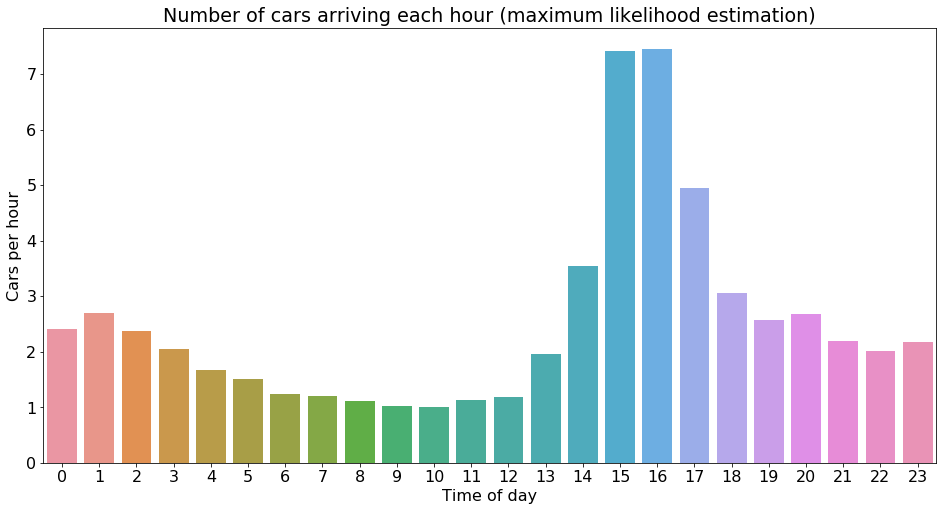

In [208]:
plt.rcParams.update({'font.size': 16})
ax, fig = plt.subplots(figsize = (16, 8))
ax = sns.barplot(x= hours, y=hourly_likelihoods)
ax.set_ylabel('Cars per hour')
ax.set_xlabel('Time of day')
ax.set_title('Number of cars arriving each hour (maximum likelihood estimation)')